In [1]:
import warnings
warnings.filterwarnings('ignore')


In [2]:
import matplotlib.pyplot as plt
import math
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import seaborn as sns
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from matplotlib.pyplot import scatter, figure
from scipy import stats
from numpy.ma.core import outer
from sys import stderr


In [3]:
start = -7
end = 7
n = 300
batch_size = 16

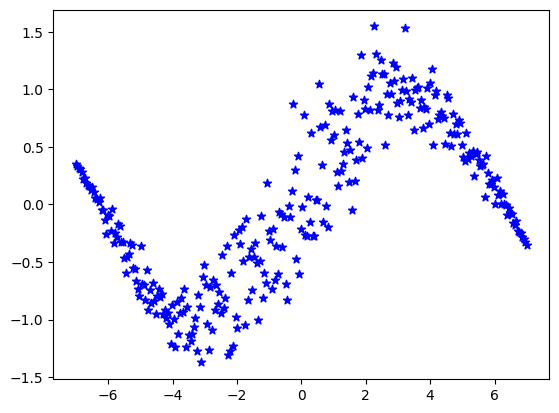

In [4]:
def sample_dataset(start, end, n):
    np.random.seed(0)
    x = np.linspace(start, end, n)
    sample_mean = [math.sin(i/2) for i in x]

    sample_var = [abs((abs(start)+abs(end))/2 - abs(i))/16 for i in x]
    y = stats.norm(sample_mean, sample_var).rvs(random_state=0)
    return x, y

x_train, y_train = sample_dataset(start, end, n)
scatter(x_train, y_train, c="blue", marker="*")

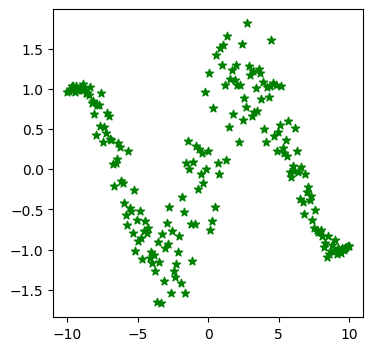

In [5]:
figure(figsize=(4, 4))
# Not exactely the same distribution, but works for now
x_test, y_test = sample_dataset(-10, 10, 200)
scatter(x_test, y_test, c="green", marker="*")

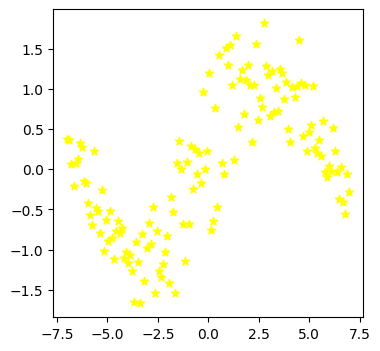

In [6]:
#Plotting In Training Distribution Data Points in the Test Set
# Filter the data to retain only the desired ranges
mask =  (x_test >= -7) &  (x_test <= 7) # Select the ranges -10 to -7 and 7 to 10
x_test_idd = x_test[mask]
y_test_idd = y_test[mask]

plt.figure(figsize=(4, 4))
plt.scatter(x_test_idd, y_test_idd, c="yellow", marker="*")

plt.show()


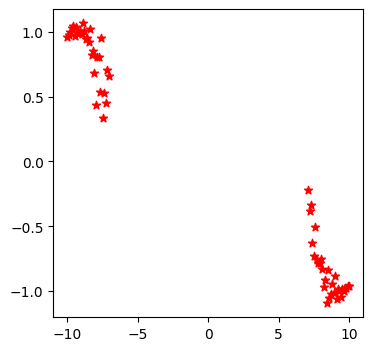

In [7]:
#Plotting Out of Training Distribution Data Points in the Test Set
# Filter the data to retain only the desired ranges
mask = (x_test >= -10) & (x_test < -7) | (x_test > 7) & (x_test <= 10) # Select the ranges -10 to -7 and 7 to 10
x_test_oodd = x_test[mask]
y_test_oodd = y_test[mask]

plt.figure(figsize=(4, 4))
plt.scatter(x_test_oodd, y_test_oodd, c="red", marker="*")

plt.show()


In [8]:

# Train
tensor_x = torch.Tensor(x_train).unsqueeze(1)
tensor_y = torch.Tensor(y_train).unsqueeze(1)
train_dataset = TensorDataset(tensor_x, tensor_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#Test for OODD (Out of Data Distribution)
tensor_x_test_oodd = torch.Tensor(x_test_oodd).unsqueeze(1)
tensor_y_test_oodd = torch.Tensor(y_test_oodd).unsqueeze(1)
test_dataset_oodd = TensorDataset(tensor_x_test_oodd, tensor_y_test_oodd)
test_loader_oodd = DataLoader(test_dataset_oodd, batch_size=batch_size, shuffle=True)

#Test for IDD (In Data Distribution)
tensor_x_test_idd = torch.Tensor(x_test_idd).unsqueeze(1)
tensor_y_test_idd = torch.Tensor(y_test_idd).unsqueeze(1)
test_dataset_idd = TensorDataset(tensor_x_test_idd, tensor_y_test_idd)
test_loader_idd = DataLoader(test_dataset_idd, batch_size=batch_size, shuffle=True)

# Test
tensor_x_test = torch.Tensor(x_test).unsqueeze(1)
tensor_y_test = torch.Tensor(y_test).unsqueeze(1)
test_dataset = TensorDataset(tensor_x_test, tensor_y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [9]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        hidden_size = 60

        # We only have 1 input feature
        self.fc1 = nn.Linear(1, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.mu = nn.Linear(hidden_size, 1)
        self.var = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h = torch.tanh(self.fc1(x))
        h = torch.tanh(self.fc2(h))
        mu = self.mu(h)
        # Exponential activation to enforce positive var
        # Arash: this might be a significant difference:
        var = torch.exp(self.var(h))
        return mu, var



In [10]:

sns.set(rc={'figure.figsize':(4, 4)})

def make_plot(model):
    # Get predictions
    mu, var = model(tensor_x_test)
    mu, sigma = mu.detach().numpy(), var.detach().numpy()**(1/2)
    # ~ 95% conf. interval (see https://en.wikipedia.org/wiki/1.96)
    y_vals = [mu, mu+2*sigma, mu-2*sigma]
    dfs = []
    # Create DF from predictions
    for i in range(3):
        data = {
              "x": list(tensor_x_test.squeeze().numpy()),
              "y": list(y_vals[i].squeeze())
        }
        temp = pd.DataFrame.from_dict(data)
        dfs.append(temp)
    df = pd.concat(dfs).reset_index()
    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")
    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)
    # Plot test data on top
    scatter(x_test, y_test, c="green", marker="*", alpha=0.5)
    plt.savefig("snn.png", dpi=300, bbox_inches='tight')  # Add this line
    plt.show()

In [11]:
#PLOTTING IN DATA DISTRIBUTION
sns.set(rc={'figure.figsize':(4, 4)})

def make_plot_idd(model):
    # Get predictions
    mu, var = model(tensor_x_test_idd)
    mu, sigma = mu.detach().numpy(), var.detach().numpy()**(1/2)

    # ~ 95% conf. interval (see https://en.wikipedia.org/wiki/1.96)
    y_vals = [mu, mu+2*sigma, mu-2*sigma]
    dfs = []

    # Create DF from predictions
    for i in range(3):
        data = {
              "x": list(tensor_x_test_idd.squeeze().numpy()),
              "y": list(y_vals[i].squeeze())
        }
        temp = pd.DataFrame.from_dict(data)
        dfs.append(temp)
    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    # Plot test data on top
    scatter(x_test_idd, y_test_idd, c="yellow", marker="*", alpha=0.5)
    plt.show()

In [12]:
#PLOTTING OUT OF DATA DISTRIBUTION
sns.set(rc={'figure.figsize':(4, 4)})

def make_plot_oodd(model):
    # Get predictions
    mu, var = model(tensor_x_test_oodd)
    mu, sigma = mu.detach().numpy(), var.detach().numpy()**(1/2)

    # ~ 95% conf. interval (see https://en.wikipedia.org/wiki/1.96)
    y_vals = [mu, mu+2*sigma, mu-2*sigma]
    dfs = []

    # Create DF from predictions
    for i in range(3):
        data = {
              "x": list(tensor_x_test_oodd.squeeze().numpy()),
              "y": list(y_vals[i].squeeze())
        }
        temp = pd.DataFrame.from_dict(data)
        dfs.append(temp)
    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    # Plot test data on top
    scatter(x_test_oodd, y_test_oodd, c="red", marker="*", alpha=0.5)
    plt.show()

In [13]:
net = SimpleNet()
print(net)
print("Params:", sum(p.numel() for p in net.parameters() if p.requires_grad))

SimpleNet(
  (fc1): Linear(in_features=1, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=60, bias=True)
  (mu): Linear(in_features=60, out_features=1, bias=True)
  (var): Linear(in_features=60, out_features=1, bias=True)
)
Params: 3902


In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Loss expects mean, variance and target
criterion = torch.nn.GaussianNLLLoss(eps=1e-02)
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [15]:
net.train()
net.to(device)

SimpleNet(
  (fc1): Linear(in_features=1, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=60, bias=True)
  (mu): Linear(in_features=60, out_features=1, bias=True)
  (var): Linear(in_features=60, out_features=1, bias=True)
)

In [16]:
def MLE_snn():
  net=SimpleNet()
  criterion = torch.nn.GaussianNLLLoss(eps=1e-02)
  optimizer = optim.Adam(net.parameters(), lr=0.001)
  net.train()
  net.to(device)
  for epoch in range(150):
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()
        mu, var = net(x)
        loss = criterion(mu, y, var)
        loss.backward()
        optimizer.step()
        criterionmse_train = nn.MSELoss()
        mse_train = criterionmse_train(mu, y)
    if epoch % 10 == 0:
        all_test_losses = []
        all_mse_test=[]
        # Test loop
        for batch in test_loader:
             x = batch[0].to(device)
             y = batch[1].to(device)
             mu, var = net(x)
             all_test_losses.append(criterion(mu, y, var).item())
             criterionmse_test = nn.MSELoss()
             all_mse_test.append(criterionmse_test(mu,y).item())
        test_loss = sum(all_test_losses)/len(all_test_losses)
        test_mse=sum(all_mse_test)/len(all_mse_test)
  make_plot(net)
  print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")
  print(f"Epoch {epoch} |batch train mse:{mse_train}| test mse:{test_mse}")
  return loss, test_loss, mse_train, test_mse


In [17]:
def MLE_snn_idd():
  net=SimpleNet()
  criterion = torch.nn.GaussianNLLLoss(eps=1e-02)
  optimizer = optim.Adam(net.parameters(), lr=0.001)
  net.train()
  net.to(device)
  for epoch in range(150):
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()
        mu, var = net(x)
        loss = criterion(mu, y, var)
        loss.backward()
        optimizer.step()
        criterionmse_train = nn.MSELoss()
        mse_train = criterionmse_train(mu, y)
    if epoch % 10 == 0:
        all_test_losses = []
        all_mse_test=[]
        # Test loop
        for batch in test_loader_idd:
             x = batch[0].to(device)
             y = batch[1].to(device)
             mu, var = net(x)
             all_test_losses.append(criterion(mu, y, var).item())
             criterionmse_test = nn.MSELoss()
             all_mse_test.append(criterionmse_test(mu,y).item())
        test_loss = sum(all_test_losses)/len(all_test_losses)
        test_mse=sum(all_mse_test)/len(all_mse_test)

  make_plot_idd(net)

  print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")
  print(f"Epoch {epoch} |batch train mse:{mse_train}| test mse:{test_mse}")
  return loss, test_loss, mse_train, test_mse


In [18]:
def MLE_snn_oodd():
  net=SimpleNet()
  criterion = torch.nn.GaussianNLLLoss(eps=1e-02)
  optimizer = optim.Adam(net.parameters(), lr=0.001)
  net.train()
  net.to(device)
  for epoch in range(150):
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()
        mu, var = net(x)
        loss = criterion(mu, y, var)
        loss.backward()
        optimizer.step()
        criterionmse_train = nn.MSELoss()
        mse_train = criterionmse_train(mu, y)
    if epoch % 10 == 0:
        all_test_losses = []
        all_mse_test=[]
        # Test loop
        for batch in test_loader_oodd:
             x = batch[0].to(device)
             y = batch[1].to(device)
             mu, var = net(x)
             all_test_losses.append(criterion(mu, y, var).item())
             criterionmse_test = nn.MSELoss()
             all_mse_test.append(criterionmse_test(mu,y).item())
        test_loss = sum(all_test_losses)/len(all_test_losses)
        test_mse=sum(all_mse_test)/len(all_mse_test)
  make_plot_oodd(net)
  print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")
  print(f"Epoch {epoch} |batch train mse:{mse_train}| test mse:{test_mse}")
  return loss, test_loss, mse_train, test_mse


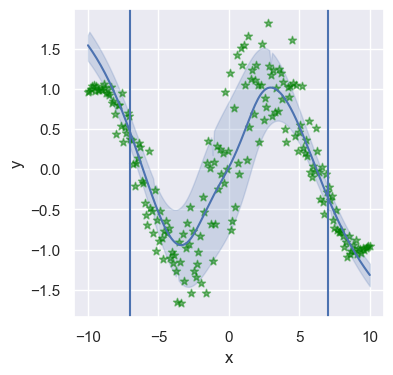

Epoch 149 | batch train loss: -1.0783839225769043 | test loss: 0.7673064561990591
Epoch 149 |batch train mse:0.04417666792869568| test mse:0.15702998294280127


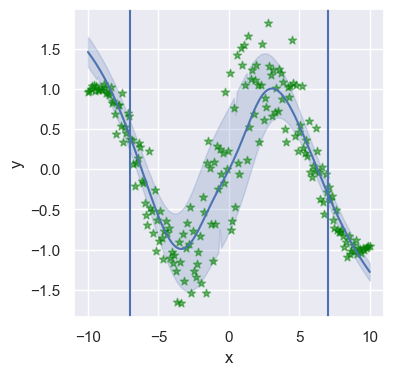

Epoch 149 | batch train loss: -1.2272132635116577 | test loss: 0.27207626975499666
Epoch 149 |batch train mse:0.03847726806998253| test mse:0.14746041911152694


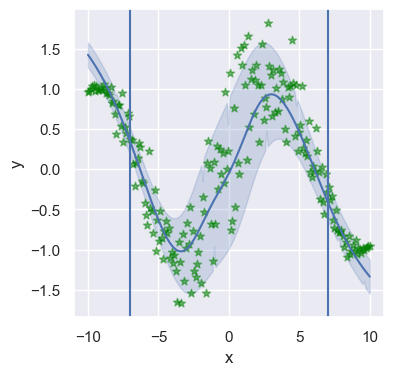

Epoch 149 | batch train loss: -0.8367190361022949 | test loss: 0.32085914336718047
Epoch 149 |batch train mse:0.08874978870153427| test mse:0.14378907201954952


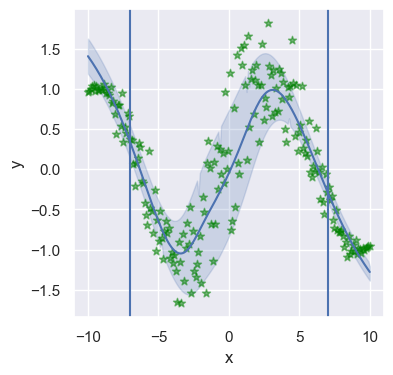

Epoch 149 | batch train loss: -1.2729699611663818 | test loss: 0.8842578759560218
Epoch 149 |batch train mse:0.029893511906266212| test mse:0.1587978062721399


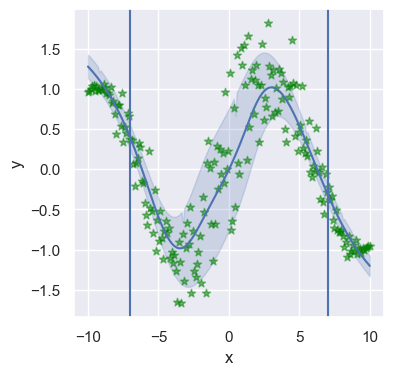

Epoch 149 | batch train loss: -0.9901742935180664 | test loss: 0.13084779049341494
Epoch 149 |batch train mse:0.1271623820066452| test mse:0.1438746781876454


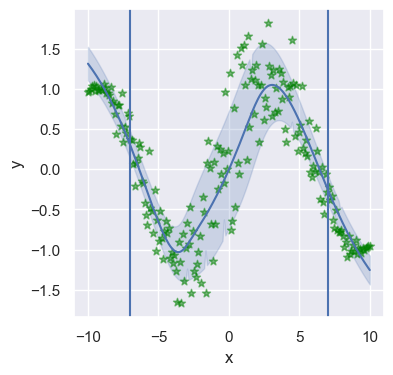

Epoch 149 | batch train loss: -0.9302737712860107 | test loss: 0.18941834970162466
Epoch 149 |batch train mse:0.07464636117219925| test mse:0.1440653199186692


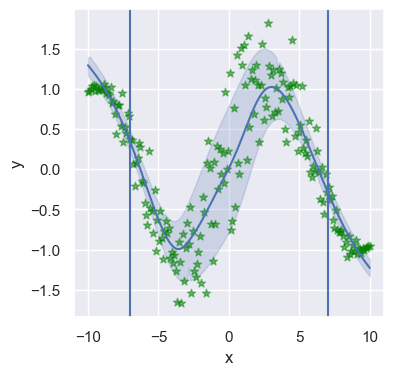

Epoch 149 | batch train loss: -0.8970138430595398 | test loss: 0.10182057321071625
Epoch 149 |batch train mse:0.06781076639890671| test mse:0.1403397464981446


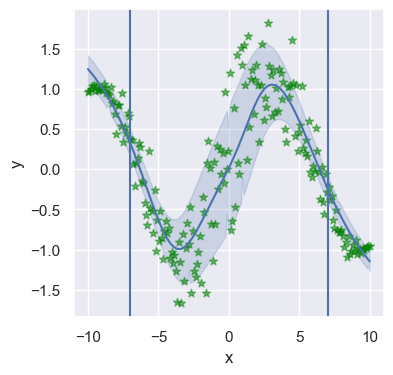

Epoch 149 | batch train loss: -1.281758427619934 | test loss: 0.11604122473643376
Epoch 149 |batch train mse:0.045122381299734116| test mse:0.14179995168860143


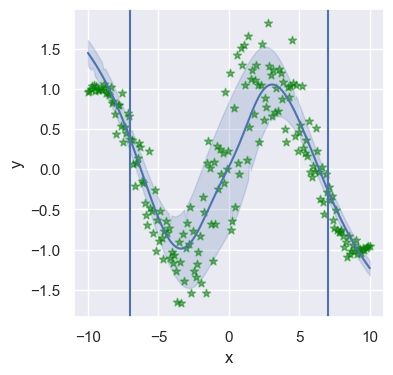

Epoch 149 | batch train loss: -1.1203819513320923 | test loss: 0.2431061348089805
Epoch 149 |batch train mse:0.04281304404139519| test mse:0.14378338937576002


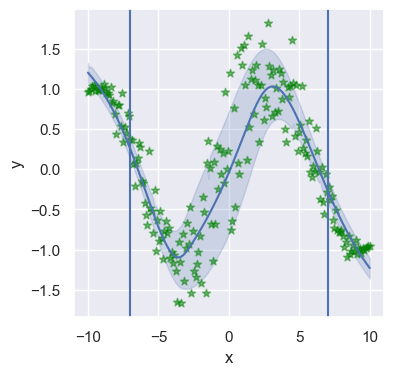

Epoch 149 | batch train loss: -1.3389339447021484 | test loss: 0.19445372430177835
Epoch 149 |batch train mse:0.020812474191188812| test mse:0.14420457041034332


In [19]:
train_losses=[]
test_losses=[]
errors_train=[]
errors_test=[]
for i in range(10):
  tr_loss,test_loss,mse_tr,mse_test = MLE_snn()
  train_losses.append(tr_loss)
  test_losses.append(test_loss)
  errors_train.append(mse_tr)
  errors_test.append(mse_test)

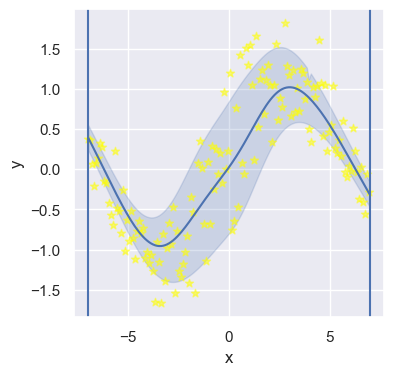

Epoch 149 | batch train loss: -1.3930519819259644 | test loss: 0.5165463238954544
Epoch 149 |batch train mse:0.030260419473052025| test mse:0.18663091543647978


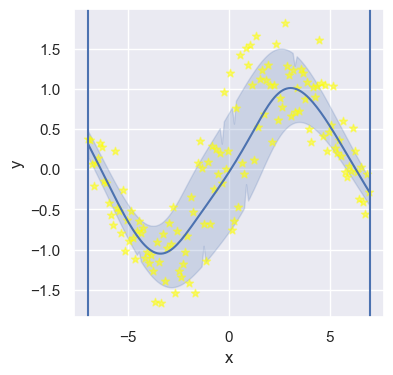

Epoch 149 | batch train loss: -0.7059441208839417 | test loss: 0.7423639799364739
Epoch 149 |batch train mse:0.13184012472629547| test mse:0.2102865684363577


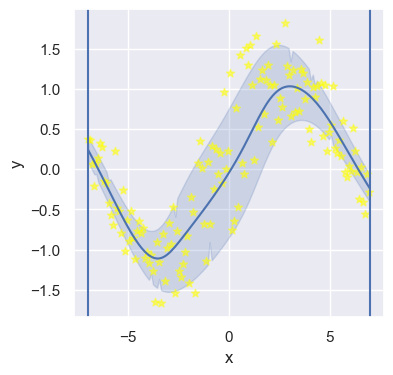

Epoch 149 | batch train loss: -1.3373149633407593 | test loss: 0.3407045155763626
Epoch 149 |batch train mse:0.0663609728217125| test mse:0.18406802415847778


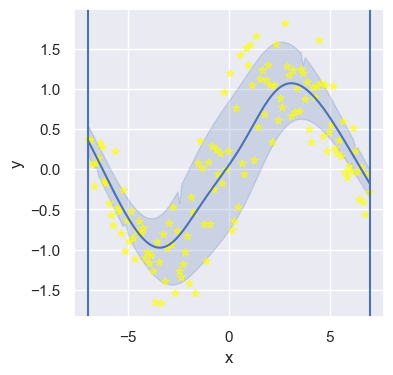

Epoch 149 | batch train loss: -1.2043017148971558 | test loss: 0.522612472375234
Epoch 149 |batch train mse:0.05911334976553917| test mse:0.20547464572721058


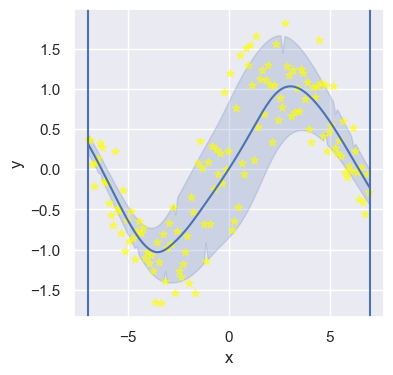

Epoch 149 | batch train loss: -0.9862602353096008 | test loss: 0.6642349147134357
Epoch 149 |batch train mse:0.05039055272936821| test mse:0.19505506091647679


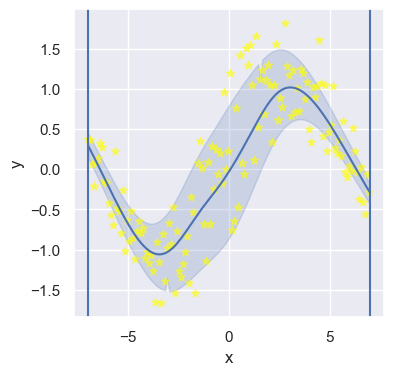

Epoch 149 | batch train loss: -1.2372550964355469 | test loss: 0.5712800837225385
Epoch 149 |batch train mse:0.05640826001763344| test mse:0.1863873153924942


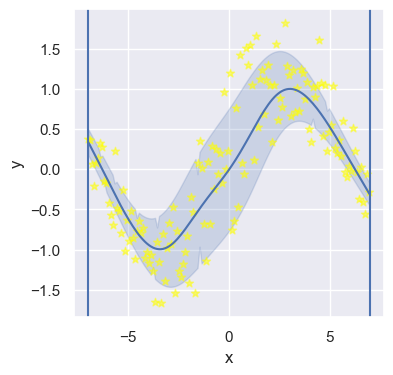

Epoch 149 | batch train loss: -1.654603362083435 | test loss: 0.5063356674379773
Epoch 149 |batch train mse:0.021347463130950928| test mse:0.18671534210443497


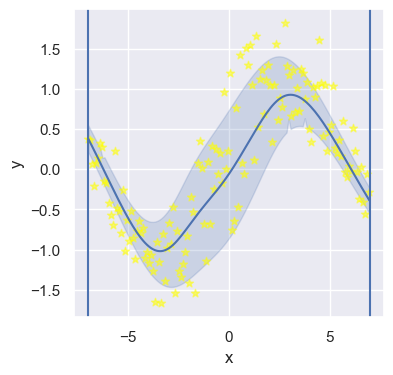

Epoch 149 | batch train loss: -0.7885578274726868 | test loss: 0.6232134335570865
Epoch 149 |batch train mse:0.08607161790132523| test mse:0.19466794199413723


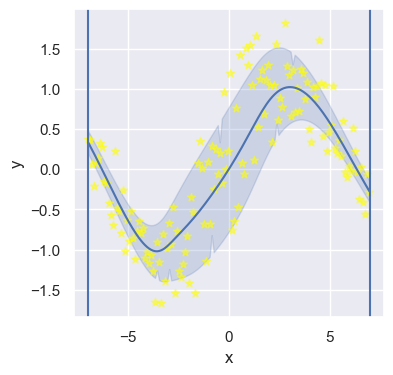

Epoch 149 | batch train loss: -0.8870916962623596 | test loss: 0.7193494273556603
Epoch 149 |batch train mse:0.09878253936767578| test mse:0.1900466788146231


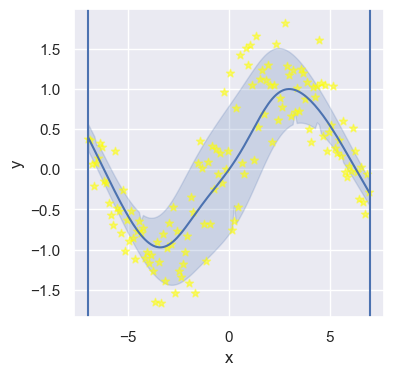

Epoch 149 | batch train loss: -1.345420479774475 | test loss: 0.5556859440273709
Epoch 149 |batch train mse:0.026026958599686623| test mse:0.18724467853705087


In [20]:
train_losses_idd=[]
test_losses_idd=[]
errors_train_idd=[]
errors_test_idd=[]
for i in range(10):
  tr_loss,test_loss,mse_tr,mse_test = MLE_snn_idd()
  train_losses_idd.append(tr_loss)
  test_losses_idd.append(test_loss)
  errors_train_idd.append(mse_tr)
  errors_test_idd.append(mse_test)

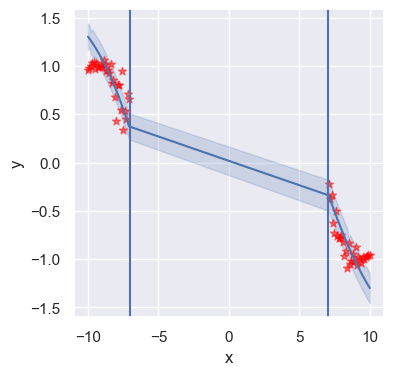

Epoch 149 | batch train loss: -1.0821770429611206 | test loss: -0.8260900676250458
Epoch 149 |batch train mse:0.09309834986925125| test mse:0.02952990075573325


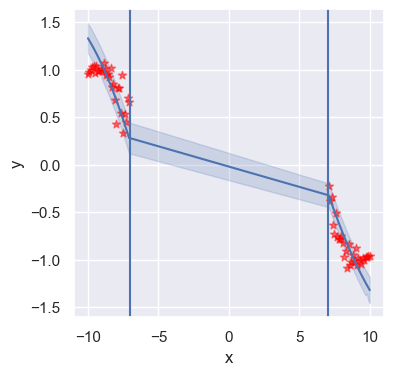

Epoch 149 | batch train loss: -0.8571718335151672 | test loss: -0.323417566716671
Epoch 149 |batch train mse:0.09626862406730652| test mse:0.03958335146307945


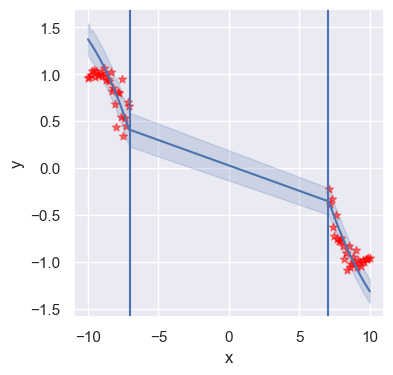

Epoch 149 | batch train loss: -1.0460189580917358 | test loss: -0.6823077537119389
Epoch 149 |batch train mse:0.06979446858167648| test mse:0.032405546866357327


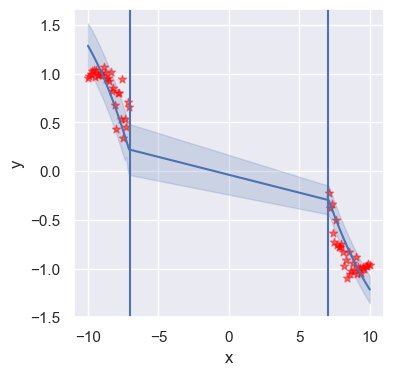

Epoch 149 | batch train loss: -0.8334158062934875 | test loss: -0.36183592677116394
Epoch 149 |batch train mse:0.07346045225858688| test mse:0.03881498472765088


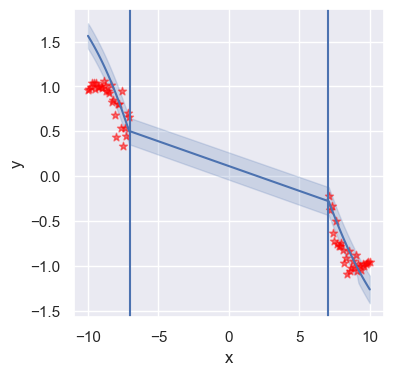

Epoch 149 | batch train loss: -1.3169130086898804 | test loss: 0.08793189376592636
Epoch 149 |batch train mse:0.04192720726132393| test mse:0.04781033983454108


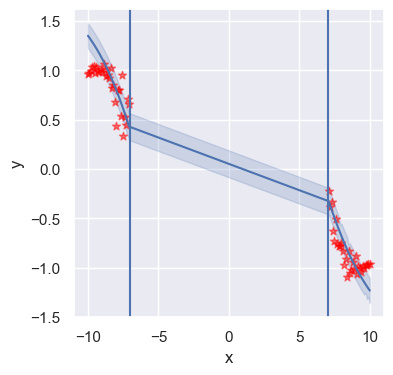

Epoch 149 | batch train loss: -1.3666361570358276 | test loss: -0.9500326216220856
Epoch 149 |batch train mse:0.05406835302710533| test mse:0.02705104975029826


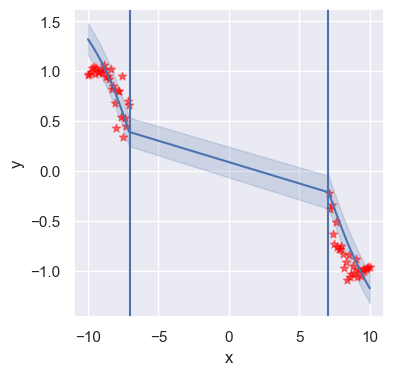

Epoch 149 | batch train loss: -0.6746087074279785 | test loss: -0.28940633684396744
Epoch 149 |batch train mse:0.12632308900356293| test mse:0.04034861037507653


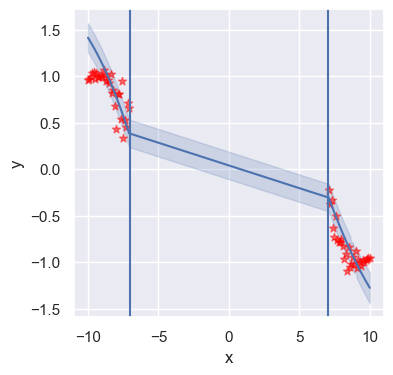

Epoch 149 | batch train loss: -1.5496788024902344 | test loss: -0.1475285366177559
Epoch 149 |batch train mse:0.023621050640940666| test mse:0.04310113051906228


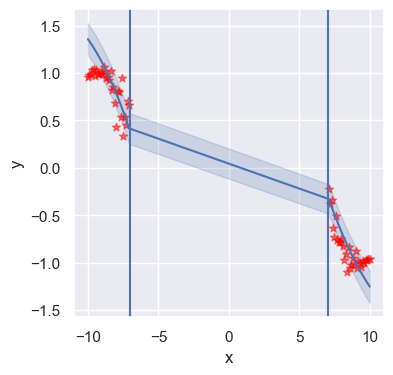

Epoch 149 | batch train loss: -1.136231780052185 | test loss: -0.7074214443564415
Epoch 149 |batch train mse:0.04481367766857147| test mse:0.032168890815228224


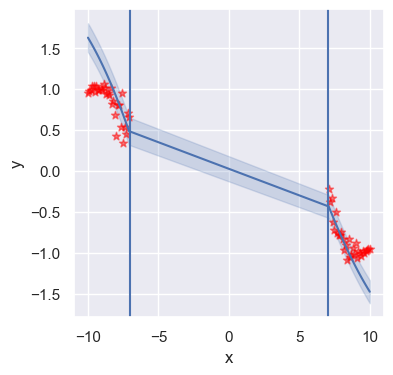

Epoch 149 | batch train loss: -1.5239700078964233 | test loss: 1.398121416568756
Epoch 149 |batch train mse:0.023510359227657318| test mse:0.0740141305141151


In [21]:
train_losses_oodd=[]
test_losses_oodd=[]
errors_train_oodd=[]
errors_test_oodd=[]
for i in range(10):
  tr_loss,test_loss,mse_tr,mse_test = MLE_snn_oodd()
  train_losses_oodd.append(tr_loss)
  test_losses_oodd.append(test_loss)
  errors_train_oodd.append(mse_tr)
  errors_test_oodd.append(mse_test)

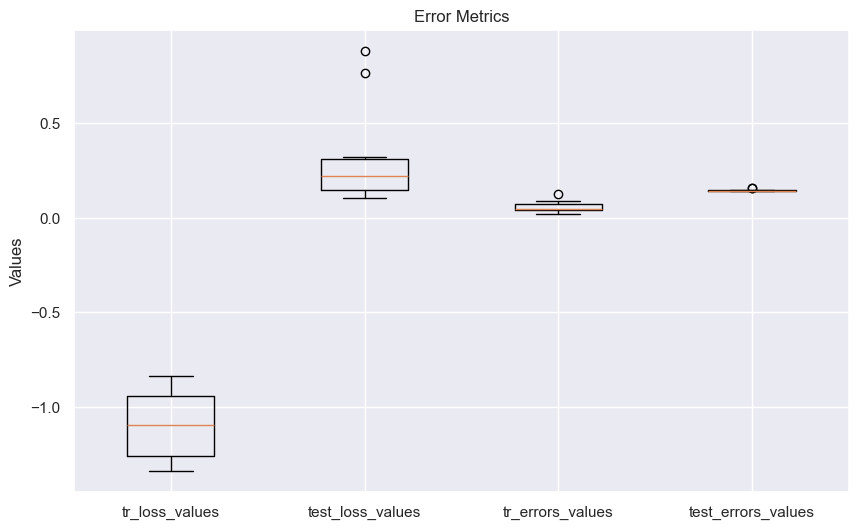

In [22]:
# Extract numerical values from the tensors and remove grad_fn
tr_loss_values= [tensor.item() for tensor in train_losses]
test_loss_values=test_losses
tr_errors_values= [tensor.item() for tensor in errors_train]
test_errors_values= errors_test

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create box plots for each dataset
box_plot_data = [tr_loss_values, test_loss_values, tr_errors_values, test_errors_values]
box_labels = ['tr_loss_values', 'test_loss_values', 'tr_errors_values', 'test_errors_values']

ax.boxplot(box_plot_data, labels=box_labels)

# Add labels and title

ax.set_ylabel('Values')
ax.set_title('Error Metrics')

# Show the plot
plt.show()


In [23]:

mean_gaus_train_loss = np.mean(tr_loss_values)
std_dev_gaus_train_loss = np.std(tr_loss_values)

mean_gaus_test_loss = np.mean(test_loss_values)
std_dev_gaus_test_loss = np.std(test_loss_values)

mean_mse_train = np.mean(tr_errors_values)
std_dev_mse_train = np.std(tr_errors_values)

mean_mse_test = np.mean(test_errors_values)
std_dev_mse_test = np.std(test_errors_values)

print('Mean of Gausiann Training Loss of 10 runs ', mean_gaus_train_loss)
print('Standard Deviation of Gausiann Training Loss of 10 runs ' , std_dev_gaus_train_loss )

print('Mean of Gausiann Testing Loss of 10 runs ',mean_gaus_test_loss )
print('Standard Deviation of Gausiann Testing Loss of 10 runs ',std_dev_gaus_test_loss)

print('Mean of MSE Training of 10 runs ',mean_mse_train)
print('Standard Deviation of MSE Training of 10 runs ' , std_dev_mse_train)

print('Mean of MSE Testing of 10 runs ',mean_mse_test )
print('Standard Deviation of MSE Testing of 10 runs ', std_dev_mse_test)

Mean of Gausiann Training Loss of 10 runs  -1.097382241487503
Standard Deviation of Gausiann Training Loss of 10 runs  0.16983240395932833
Mean of Gausiann Testing Loss of 10 runs  0.3220187542530206
Standard Deviation of Gausiann Testing Loss of 10 runs  0.26161666395301264
Mean of MSE Training of 10 runs  0.057966464571654795
Standard Deviation of MSE Training of 10 runs  0.030403800480152003
Mean of MSE Testing of 10 runs  0.14651449364251817
Standard Deviation of MSE Testing of 10 runs  0.00596568641439752


In [24]:
# Create a DataFrame from the lists
data = {
    'Training Loss': tr_loss_values,
    'Testing Loss': test_loss_values,
    'Mean Squared Training Error': tr_errors_values,
    'Mean Squared Testing Error': test_errors_values
}

num_columns = len(data)

column_names = ['Training Loss','Testing Loss', 'Mean Squared Training Error','Mean Squared Testing Error']

# Create a DataFrame with dynamic column names
df = pd.DataFrame(data, columns=column_names)
df.index += 1
# Display the DataFrame as a table
print(df)
df.to_csv('results_snn.csv', index=True)

    Training Loss  Testing Loss  Mean Squared Training Error  \
1       -1.078384      0.767306                     0.044177   
2       -1.227213      0.272076                     0.038477   
3       -0.836719      0.320859                     0.088750   
4       -1.272970      0.884258                     0.029894   
5       -0.990174      0.130848                     0.127162   
6       -0.930274      0.189418                     0.074646   
7       -0.897014      0.101821                     0.067811   
8       -1.281758      0.116041                     0.045122   
9       -1.120382      0.243106                     0.042813   
10      -1.338934      0.194454                     0.020812   

    Mean Squared Testing Error  
1                     0.157030  
2                     0.147460  
3                     0.143789  
4                     0.158798  
5                     0.143875  
6                     0.144065  
7                     0.140340  
8                     0.141800 

In [25]:
print(test_errors_values)

[0.15702998294280127, 0.14746041911152694, 0.14378907201954952, 0.1587978062721399, 0.1438746781876454, 0.1440653199186692, 0.1403397464981446, 0.14179995168860143, 0.14378338937576002, 0.14420457041034332]
